## Purpose of this notebook

KOOP [Handleiding SRU 2.0](https://www.google.com/search?q=KOOP+Handleiding+SRU+2.0) briefly mensions BUS,
the Bulk Uitlever Systeem, as being a place that contains the files,
and being present at `sftp://bestanden.officielebekendmakingen.nl`

This explains why and when this may be useful - hopefully in contrast with the other ways of getting at similar data.

### For context; and, when this is and is not useful

If you've stared at the raw XML of SRU responses, you might have noticed that, 
when search results point at the documents they describe,
they link to different places. 

Beyond HTTP links onto `zoek.officielebekendmakingen.nl`, `repository.officiele-overheidspublicaties.nl`, and `repository.overheid.nl/frbr`,
there are also SFTP links to `bestanden.officielebekendmakingen.nl`. And some further cross-site links - the data resources notebook mentions some more on that.


Anyway, the SFTP store seems to contain a whole lot of officiele publicaties, plus some parliamentary documents.

In fact, it seems to _mostly_ duplicate the contents on `repository.overheid.nl/frbr`, though not entirely one-to-one?

It is relevant that SFTP is more geared to do a bunch of download - certainly faster than save-as-ing from websites,
and arguably more accessible than trying to use that FRBR to download from. 

That said, even ''with'' that protocol, serially walking the entire repository goes at at perhaps 40 items/sec
(~30 items/sec when you also ask ask for their size and modification time, e.g. if you want to later only download changes).

That might not seem _too_ slow, but at ~26 million files (in ~4 million document sets),
even just _listing_ all of those files will take two weeks. 

Downloading probably doubles that. So it's not quite as bulk as advertised, though frankly...

### How much of that do you really need?

You probably do not want to download everything.

Legal research has interest in specific subset documents that are _hopefully_ easy to determine,
and often a small_ish_ set.

Even if you are on the NLP, "more data is better" side of things,
you may still only care to have _enough_ data to prove that something works or not, 
and still probably just want a decent sample and not everything.

#### Many things are duplicated in multiple formats

Consider the following estimates:

               pdf    1.3 TiB
        odt or odf    388 GiB
              html    121 GiB
          data xml     36 GiB
      metadata xml     12 GiB

In terms of bytes, ~70% of that is PDF and another ~15% is office documents,
but a lot of that (yet not _all_) is _also_ available in both HTML and XML form.
And if you care primarily about the text they contain,
all of these are more or less equivalent (the ease of _extracting_ it varies, though).

So if we were to choose a single item from each set.

If we could stick to just XML, we would need only a few percent, byte-wise. 
Because some things are only available only in PDF, it turns out to be as much as 10% of that.
Still pretty good savings.

(Note that the above is only an estimate, because this is just a total by file suffix, not considering the best option within each logical document - we get into that below)

#### Your interest is probably in only one area

Consider the following areas:

      stcrt      290GiB
        stb       27GiB
        gmb      1.3TiB
        prb       35GiB
        wsb       51GiB
        bgr        6GiB
        trb      7.5GiB
        
And, on the parliament side:

        kst       50GiB
          h       17GiB
        blg      108GiB
         ah      4.6GiB
         ag      230MiB
         kv      2.4GiB
        nds      1.6GiB

Chances are you are only interested in one of these at a time.

...and further filtered by just one format, that may already make your data _much_ more manageable.

#### You may only be interested in some years

A lot of research may not be interested in decades of data.

This helps less, at least in terms of bytes, because often your time preference is "in the last few years",
which is where most of the size is.

Consider the following estimates:
- there are <3K files (<1GB) pear year up to 1994, 
- < 100K per year (<5G) up to 2007ish, 
- and ~>1M ~(100GB) per year since 2015 or so.


And if doing this for just the text content, then consider the code below,
which tries to find the smallest structured file within each document set.

This allows you to skip the bulk of PDFs and most officode documents, 
and means you can need only fetch around 250GB in 5 million files, and not the full 1.9TB in 26 million files.

# Okay, but how do I get to what's in BUS?

In [2]:
import re, random, collections, pprint

import lxml.etree
import pandas

import wetsuite.datacollect.koop_bus
import wetsuite.helpers.localdata
import wetsuite.helpers.notebook
import wetsuite.helpers.koop_parse
import wetsuite.helpers.format
import wetsuite.helpers.etree
import wetsuite.helpers.split

# Setting up a connection

The repository is provided over SFTP, a thing that wraps SSH (Secure Shell, usually used for remote logins).

Normally you wouldn't care about _how_ the data is transferred,
but in this case, this repository did something rather unusual with their login process,
that confuses the negotiation part of various SSH libraries.

As a result, if this doesn't work immediately, that's probably not on you. 
Consult a security nerd, and/or tell us to do better.

Separately, the server refuses connections if you already have two connections active -- for given values of 'you' and of 'active'.

We give you a simple class that, ideally, makes it a little simpler to use just one connection,
and reconnects for you if it can.

In [10]:
# This is a test of whether it will connect, 
# and a short introduction of interaction. Code below does more.
bf = wetsuite.datacollect.koop_bus.BUSFetcher() # mainly to remember its connection

print( "Listing..." )
that_gmb_list = bf.list( 'ftps://bestanden.officielebekendmakingen.nl/2024/05/17/gmb/gmb-2024-216934/' )
#wetsuite.datacollect.koop_bus.list_bus( '/2024/05/17/gmb/gmb-2024-216934/' )   # we assume that hostname internally, so this will do the same

pprint.pprint( that_gmb_list )

print( "\nExample fetch..." )
for relpath in that_gmb_list:
    print( relpath )
    print( bf.get_bytes( relpath )[:60] ) # not to use, just to prove it fetched
    break # just the first in the list, actually

Listing...
['/2024/05/17/gmb/gmb-2024-216934/gmb-2024-216934.html.zip',
 '/2024/05/17/gmb/gmb-2024-216934/gmb-2024-216934.odt',
 '/2024/05/17/gmb/gmb-2024-216934/gmb-2024-216934.pdf',
 '/2024/05/17/gmb/gmb-2024-216934/gmb-2024-216934.xml',
 '/2024/05/17/gmb/gmb-2024-216934/metadata.xml',
 '/2024/05/17/gmb/gmb-2024-216934/metadata_owms.xml']

Example fetch...
/2024/05/17/gmb/gmb-2024-216934/gmb-2024-216934.html.zip
b'PK\x03\x04\x14\x00\x00\x00\x08\x00\xa3J\xb1X2,KVD\x13\x00\x00\xc49\x00\x00\x14\x00\x00\x00gmb-2024-216934.html\xc5[\xe9r\xdb\xca\xb1\xfe\x9f\xa7'


# Setting up the store to fetch to

In [13]:
# we'll be using both of these
bus_listing   = wetsuite.helpers.localdata.MsgpackKV( 'bus_meta.db', key_type=str )                 # path -> dict of some details
bus_documents = wetsuite.helpers.localdata.LocalKV(   'bus_data.db', key_type=str, value_type=bytes ) # path -> stored file

## Fetching an index - paths and sizes

WARNING: as mentioned above, this will take two weeks if you run it on _everything_, just by merit of 26 million items.
And that's only to _list_ everything, not even fetch anything yet.

Be sure you have a goal and actually _want_ to do this -- we provide datasets based on having done this already.

In [6]:
# The sftp walktree() wants to call a function for each file, directory, and other that it it meets.
# 
# These particular set of callbacks are set up only to create a list of what is in there.
# 
# Annoyingly, the sftp interface does not report mtime for directories, 
#   so we can't make the significant optimization that e.g. mlocate does.

item_count = 0 # a "we saw this many items this session" type thing, could be removed

def file_callback(path):
    ' store existence of path, plus reported size and mtime '
    global item_count
    item_count += 1
    if path in bus_listing: # assume no changes for now, is a little faster
        # TODO: allow checking whether it has changed
        return 
    else:
        stob         = bf.connect().stat(path)
        remote_size  = stob.st_size
        remote_mtime = stob.st_mtime
        bus_listing.put( path, {'type':'file', 'size':remote_size, 'mtime':remote_mtime} )

def dir_callback(path):
    ' ignore '
    global item_count
    item_count += 1
    #stob  = sftp.stat(path)
    #size  = stob.st_size
    #mtime = stob.st_mtime
    #print( f'DIR  {path}')

def unknown_callback(path): 
    ' ignore, but mention that it happens '
    global item_count
    item_count += 1
    print( 'UNKNOWN', path )

In [7]:
# a single day can be assumed to take fifteen minutes (~25k files),
# bf.connect().walktree('/2024/05/08/', file_callback, dir_callback, unknown_callback) # example that should take a minute

# a single month a few hours
# bf.connect().walktree('/2024/05/', file_callback, dir_callback, unknown_callback)

# narrower example (a few hundred files) that should less than a minute
bf.connect().walktree('/2024/05/08/wsb/', file_callback, dir_callback, unknown_callback)
item_count  # how many items did those callback just pass over?
# (helps get an idea of how much there is per the interval you just ran it on)

854

### Summarize what that that stored listing we just made/updated says is there

#### Get an idea of counts and sizes - per year, per file type, and per area

In [47]:
# will take a few minutes  (IO and decoding ~26 million msgpack items)

sizes_per_year = collections.defaultdict(list) # e.g. '1995' -> [19223, 23428, 23423]     
sizes_per_type = collections.defaultdict(list) # e.g. 'xml'  -> [6034, 5284, 3892]        
sizes_per_area = collections.defaultdict(list) # e.g. 'kst'  -> [12356, 12321]
# note: size list rather than total, so that we can get both doc count and total size later
file_count, total_size = 0, 0

for relpath, details in bus_listing.items(): 
    # relpath looks like  '/2023/12/34/bgr/bgr-2023-1234/bgr-2023-1234.xml'
    # details looks like  {'type': 'file', 'size': 12345, 'mtime': 1701123456})
    year         = relpath.split('/')[1]      # picks out '2023'. we could do a fancier split (that is also more readable), but don't really need to right now
    _,gid,brpath = relpath.rsplit('/',2)      # picks out 'bgr-2023-1234' and 'bgr-2023-1234.xml'
    area         = gid.split('-')[0].lower()  # picks out 'bgr' (from the id; brpath might be something like 'metadata.xml')
    ftyp         = brpath.split('.',1)[1]     # picks out 'xml'
    # CONSIDER: use wetsuite.datacollect.koop_bus.id_from_path and make similar helpers to make the above more readable

    if details['type'] == 'file':   # (which is currently all, but that may change)
        file_count += 1
        remote_size = details['size']
        total_size += remote_size

        if 'changelog' in brpath:
            #typ = '(changelog)'
            continue # actually, just ignore those
        
        if 'metadata' in brpath:
            ftyp = '(meta)' # rather than the xml it technically is

        if ftyp=='html.zip':
            ftyp = 'html'   # treat html.zip and html as the same in this summary

        sizes_per_year[year].append( remote_size )
        sizes_per_area[area].append( remote_size )
        sizes_per_type[ftyp].append( remote_size )

In [48]:
# print out the results of the above
print( 'TOTAL   %5sB  in %d items'%( wetsuite.helpers.format.kmgtp(total_size, kilo=1024), file_count) )

TOTAL   1.9TiB  in 26812665 items


In [49]:
for year, year_sizelist in dict(sizes_per_year).items():
    # hardcodig GB rather than using kmgtp() to make it more visually comparable
    print( f'%8s   %4.1fGiB  in %d items'%(year, sum(year_sizelist)/(1024.**3), len(year_sizelist)) ) 

    1922    0.0GiB  in 3 items
    1951    0.4GiB  in 2312 items
    1952    0.4GiB  in 2708 items
    1953    0.4GiB  in 2502 items
    1954    0.5GiB  in 2839 items
    1955    0.4GiB  in 2516 items
    1956    0.1GiB  in 714 items
    1957    0.4GiB  in 2757 items
    1958    0.4GiB  in 2763 items
    1959    0.1GiB  in 988 items
    1960    0.4GiB  in 2435 items
    1961    0.4GiB  in 2228 items
    1962    0.4GiB  in 2418 items
    1963    0.5GiB  in 2599 items
    1964    0.4GiB  in 2559 items
    1965    0.4GiB  in 2277 items
    1966    0.5GiB  in 3101 items
    1967    0.5GiB  in 2992 items
    1968    0.5GiB  in 2969 items
    1969    0.5GiB  in 2989 items
    1970    0.5GiB  in 2821 items
    1971    0.6GiB  in 3476 items
    1972    0.5GiB  in 3006 items
    1973    0.4GiB  in 2835 items
    1974    0.5GiB  in 3531 items
    1975    0.5GiB  in 2928 items
    1976    0.5GiB  in 2335 items
    1977    0.5GiB  in 3136 items
    1978    0.5GiB  in 2992 items
    1979    0.5GiB 

In [52]:
for typ, typ_sizelist in dict(sizes_per_type).items():
    print( f'%8s   %7sB  in %d items'%(typ, wetsuite.helpers.format.kmgtp(sum(typ_sizelist), kilo=1024), len(typ_sizelist)) )

  (meta)      17GiB  in 8563796 items
     pdf     1.4TiB  in 4846464 items
html.zip     123GiB  in 4584570 items
     xml      36GiB  in 4598118 items
     dat     1.6KiB  in 1 items
     odt     381GiB  in 3974450 items
     odf    12.5GiB  in 217162 items
    html     302MiB  in 12812 items


In [55]:
for typ, area_sizelist in dict(sizes_per_area).items():
    print( f'%8s   %8sB  in %d items'%(typ, wetsuite.helpers.format.kmgtp(sum(area_sizelist), kilo=1024), len(area_sizelist)) )

     stb       27GiB  in 166383 items
     trb      7.5GiB  in 72188 items
    1951      1.6KiB  in 1 items
   stcrt      290GiB  in 2696820 items
       h       17GiB  in 251524 items
     kst       50GiB  in 1468147 items
      ah      4.6GiB  in 374254 items
      ag      230MiB  in 9049 items
     blg      108GiB  in 224335 items
      kv      2.4GiB  in 269221 items
   Stcrt       98MiB  in 468 items
     nds      1.6GiB  in 58569 items
     Kst      125KiB  in 3 items
               41KiB  in 3 items
     wsb       51GiB  in 806582 items
     gmb      1.3TiB  in 19741765 items
     prb       35GiB  in 598689 items
     bgr        6GiB  in 59372 items


# Fetching some actual documents

## ...decide somewhat adaptively

It would be nice if everything has data as something like XML (because it's likely to be stored relatively semantically),
but let's check whether there is indeed an XML for every document set.

To that end, we group all indexed things by the ID that joins them.

for example, we would want to see groups like:

     'gmb-2019-276546' -> { 'html.zip': '/2019/11/14/gmb/gmb-2019-276546/gmb-2019-276546.html.zip',
                            'odt': '/2019/11/14/gmb/gmb-2019-276546/gmb-2019-276546.odt',
                            'pdf': '/2019/11/14/gmb/gmb-2019-276546/gmb-2019-276546.pdf',
                            'xml': '/2019/11/14/gmb/gmb-2019-276546/gmb-2019-276546.xml',
                            '(meta)': '/2019/11/14/gmb/gmb-2019-276546/metadata_owms.xml'    } 
     'stcrt-2024-1975' -> { '(meta)': '/2024/01/18/stcrt/stcrt-2024-1975/metadata_owms.xml',
                            'pdf': '/2024/01/18/stcrt/stcrt-2024-1975/stcrt-2024-1975.pdf'   }



In [14]:
# will take minute or two going through that long listing
groups = collections.defaultdict(dict)  

for key in bus_listing.keys(): 
    # Ignore some things that we know aren't data. Maybe should have been done earlier
    if key.endswith('changelog.xml'):
        continue
    if key.endswith('config.dat'):
        continue
    # would look like "/1956/06/13/trb/trb-1956-50/trb-1956-50.html.zip",
    mob = re.match('(/([0-9][0-9][0-9][0-9])/([0-9][0-9])/([0-9][0-9])/([A-Za-z]+)/([A-Za-z0-9-]+)/([A-Za-z0-9_-]+))[.]([a-z.]+)', key)
    if mob is None:
        pass
        #print( 'POSSIBLE PROBLEM %r'%key )
    else:
        # split off both metadata .xml files into their own (pseudo)types so that they get handled separately later
        pre, year, month, day, typ, id, fn, ext = mob.groups()
        if 'metadata_owms' in fn:
            ext = '(meta_owms)'
        elif 'metadata' in fn:
            ext = '(meta)'
        groups[id][ext] = key

In [16]:
# how many document sets are there?
print( len(groups) )

# print a few examples
random.sample(list(groups.items()), 5)

4865025


[('bgr-2019-32',
  {'html.zip': '/2019/01/09/bgr/bgr-2019-32/bgr-2019-32.html.zip',
   'odt': '/2019/01/09/bgr/bgr-2019-32/bgr-2019-32.odt',
   'pdf': '/2019/01/09/bgr/bgr-2019-32/bgr-2019-32.pdf',
   'xml': '/2019/01/09/bgr/bgr-2019-32/bgr-2019-32.xml',
   '(meta)': '/2019/01/09/bgr/bgr-2019-32/metadata.xml',
   '(meta_owms)': '/2019/01/09/bgr/bgr-2019-32/metadata_owms.xml'}),
 ('gmb-2021-255499',
  {'html.zip': '/2021/08/05/gmb/gmb-2021-255499/gmb-2021-255499.html.zip',
   'odt': '/2021/08/05/gmb/gmb-2021-255499/gmb-2021-255499.odt',
   'pdf': '/2021/08/05/gmb/gmb-2021-255499/gmb-2021-255499.pdf',
   'xml': '/2021/08/05/gmb/gmb-2021-255499/gmb-2021-255499.xml',
   '(meta)': '/2021/08/05/gmb/gmb-2021-255499/metadata.xml',
   '(meta_owms)': '/2021/08/05/gmb/gmb-2021-255499/metadata_owms.xml'}),
 ('h-ek-20132014-38-11',
  {'html': '/2014/08/28/h/h-ek-20132014-38-11/h-ek-20132014-38-11.html',
   'odt': '/2014/08/28/h/h-ek-20132014-38-11/h-ek-20132014-38-11.odt',
   'pdf': '/2014/08/28/h/

Say that, within each such document group, we want to fetch _only_ the best one available

...'best' by our own, configurable logic, e.g. we prefer xml data over pdf, or perhaps odt over both?

We are then interested in how much that reduces the amount of things to fetch,
to summarize that per area to see if there are any broad patterns, so:
  - count how often each appeared, without our preference choice
  - count how often each appeared, with our preference choice
  - currently only counting document types per area, 
    e.g. 'h': defaultdict(int, {'xml': 56387, '(meta)': 25122, 'pdf': 69}),


In [17]:
# At the same time, we might, per group, list just the documents we are interested in
#   so we can actually fetch them
groups_chosen = {} 

# these two are just for some graphs
all_counter    = collections.defaultdict(lambda: collections.defaultdict(int) )
chosen_counter = collections.defaultdict(lambda: collections.defaultdict(int) )

for groupid, groupdict in groups.items():

    area = groupid.split('-',1)[0].lower()

    # there previously was some filtering here, now there's just normalizing html/html.zip
    filt_gd = {} # 
    for k, v in groupdict.items():
        if k=='html.zip':
            k = 'html'
        all_counter[area][k] += 1
        filt_gd[k] = v

    groups_chosen[groupid] = {}

    options = list( filt_gd.keys() )
    # we could alter prefer_types to do this in one, but it'd be awkward to specify
    # so we do it in two:
    # - add document; prefer XML over HTML over office document over PDF  (you can argue over this order)
    for preferred_type in wetsuite.helpers.koop_parse.prefer_types( 
            options,
            all_of         =(),
            first_of       =('xml','html', 'html.zip', 'odt', 'odf', 'pdf'),
            require_present=(),
            never          =('(meta)','(meta_owms)'),
        ):
        chosen_counter[area][preferred_type] += 1
        groups_chosen[groupid][preferred_type] = filt_gd[preferred_type]
    # - add the preferred metadata type (we can parse both)
    for preferred_type in wetsuite.helpers.koop_parse.prefer_types( 
            options, 
            all_of         =(),
            first_of       =('(meta)','(meta_owms)'),
            require_present=(),
            never          =('xml','html', 'html.zip', 'odt', 'odf', 'pdf'),
        ):
        chosen_counter[area][preferred_type] += 1
        groups_chosen[groupid][preferred_type] = filt_gd[preferred_type]
    # note that while prefer_types() can return multiple types, the way we use it here should return (a list of) one

In [18]:
# the amount of documents+meta in each
dict( chosen_counter )

{'stb': defaultdict(int, {'pdf': 29582, '(meta)': 35105, 'xml': 19017}),
 'trb': defaultdict(int, {'xml': 15682, '(meta)': 9895, 'pdf': 3}),
 'stcrt': defaultdict(int,
             {'xml': 458762,
              '(meta)': 399849,
              'html': 2531,
              'pdf': 127899,
              '(meta_owms)': 4,
              'odt': 2}),
 'h': defaultdict(int, {'xml': 56391, '(meta)': 25126, 'pdf': 69}),
 'kst': defaultdict(int,
             {'xml': 326286, '(meta)': 153334, 'pdf': 793, 'odf': 2}),
 'ah': defaultdict(int, {'xml': 84526, '(meta)': 35216, 'pdf': 583}),
 'ag': defaultdict(int, {'xml': 2165, '(meta)': 728, 'pdf': 86}),
 'blg': defaultdict(int, {'xml': 2807, '(meta)': 66664, 'pdf': 82581}),
 'kv': defaultdict(int, {'xml': 63738, '(meta)': 27427, 'pdf': 405}),
 'nds': defaultdict(int, {'xml': 11807, 'pdf': 822, '(meta)': 6598}),
 'wsb': defaultdict(int,
             {'xml': 139306, '(meta)': 130702, 'html': 17, 'odt': 3}),
 'gmb': defaultdict(int,
             {'xml': 33

That looks like areas do not uniformly have everything -- it's more of a mis.
We would want to look at that in more detail.
(Maybe that's mostly early years, pre-digitization, or are there more shifts?)

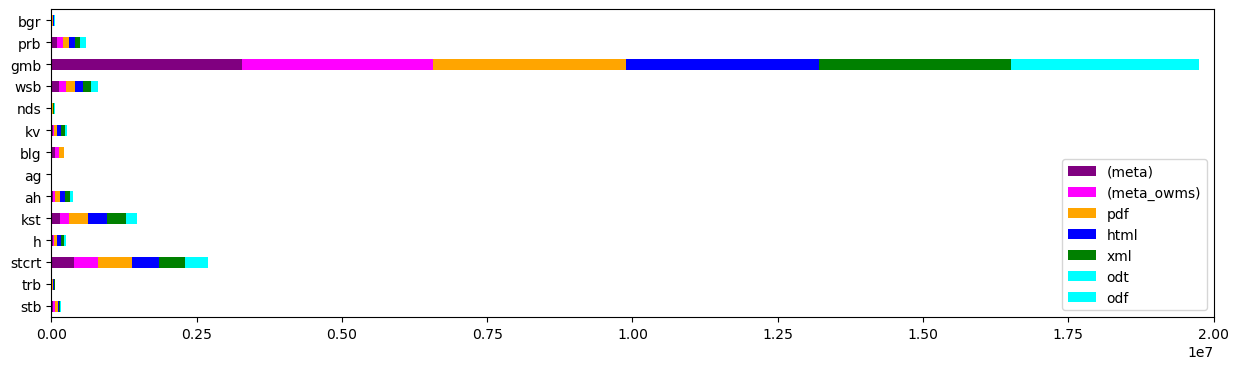

In [19]:
# draw the counts per area
colors = {'xml':'green', 'odt':'cyan','odf':'cyan', 'html':'blue', 'pdf':'orange', '(meta)':'purple','(meta_owms)':'magenta'}

df = pandas.DataFrame.from_dict(all_counter, orient='index')   # this happens to wrangle that nested structure well enough
df.plot.barh( stacked=True, figsize=(15, 4), xlim=(0,2E7), color=colors )

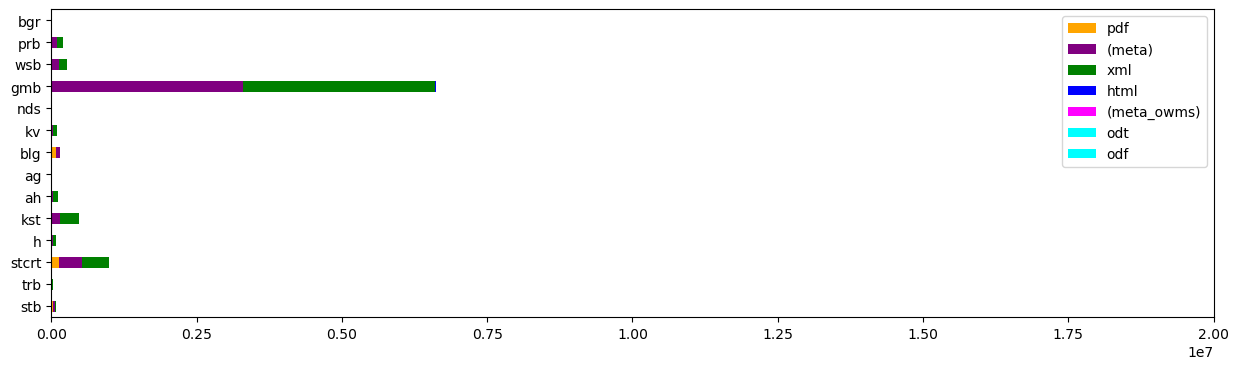

In [20]:
# and the preference-filtered version
df = pandas.DataFrame.from_dict(chosen_counter, orient='index')
df.plot.barh( stacked=True, figsize=(15, 4), xlim=(0,2E7), color=colors ) # put on roughly the same scale as the previous

In [21]:
# Optional: (not necessary, just out of interest)

# So how much did we really select? 
# That graph gives us a _count_, 
# but half of that is tiny metadata, and the XML probably isn't very large either.
# This counts how much that amounts to in _bytes_. 

# This may take a few minutes
chosen_byte_sum, chosen_doc_count = 0, 0
for key, types_docs in groups_chosen.items():
    for type, doc_relpath in types_docs.items():
        chosen_doc_count += 1
        meta_dict = bus_listing.get(relpath)
        chosen_byte_sum += meta_dict['size']

wetsuite.helpers.format.kmgtp(chosen_byte_sum)+f'B  in {chosen_doc_count} items'

'46GB  in 9148726 items'

## Finally some actual content fetching

We have listed what's in the store, 
we have decided which metadata and documents are interesting to us.

Now let's fetch them.

In [ ]:
### Make list of remote paths to fetch
# shuffle to make the progress bar more representative (puts unfetched items in random places)
print('making list...') 
fetch_relpaths = set()
for key, types_docs in groups_chosen.items():
    for type, doc_relpath in types_docs.items():
        fetch_relpaths.add( doc_relpath )
print('shuffling...') 
fetch_relpaths = list(fetch_relpaths)
random.shuffle( fetch_relpaths )


### Fetch
print('fetching...') 
# with progress bar because this will take some time to go through
pb = wetsuite.helpers.notebook.progress_bar(len(fetch_relpaths))
# counts some division of results during the fetching, show in in that progress bar
counter = collections.defaultdict( int ) 

for relpath in fetch_relpaths:
    #meta_dict = bus_listing.get(relpath)

    # fetching logic
    if relpath in bus_documents:
        counter['have-already'] += 1
    else:
        try:
            docbytes = bf.get_bytes(relpath)
            bus_documents.put( relpath, docbytes ) # (could wrap a try around this too)
            counter['fetched'] += 1
        except Exception as e: # TODO: a more precise exception
            print( 'ERROR fetching %r: %s'%(relpath, e) )
            counter['fetch-error'] += 1

    pb.value += 1
    if ( pb.value % 100 ) == 0:
        pb.description = ', '.join( '%s:%d'%(what,count)   for what, count in counter.items() )

# Start to make datasets of it

In [205]:
# def guess_url(id, type):
#     area, rest = id.split('-',1)
#     if area == 'kst':
#         return f'https://repository.overheid.nl/frbr/officielepublicaties/{area}/20487-32/kst-20487-32-b2/1/pdf/kst-20487-32-b2.pdf
#     else:
#         return 'https://repository.overheid.nl/frbr/officielepublicaties/gmb/2020/gmb-2020-1000/1/metadataowms/metadata_owms.xml'

In [26]:
# We split into different-themed stores
bus_extracted_parl  = wetsuite.helpers.localdata.MsgpackKV( 'bus_extracted_parl.db', key_type=str )      # path -> dict of some details
bus_extracted_local = wetsuite.helpers.localdata.MsgpackKV( 'bus_extracted_local.db', key_type=str )     
bus_extracted_staat = wetsuite.helpers.localdata.MsgpackKV( 'bus_extracted_staat.db', key_type=str )     
#._put_meta()

def grouped_store_for_id(id):
    ' Given an identifier (like kst-20487-32-b2), returns a reference to the store it should go into '
    areafirst = id.split('-')[0]
    if areafirst.lower() in ('h','ah','ag','kv','kst','blg','nds'):
        return bus_extracted_parl#'parl'
    if areafirst.lower() in ('gmb','prb','wsb','blg','bgr','trb'):
        return bus_extracted_local#'local'
    if areafirst.lower() in ('stcrt','stb'):
        return bus_extracted_staat#'staat'
    raise ValueError(areafirst)

In [ ]:
from importlib import reload
reload( wetsuite.helpers.split )

#selection = random.sample( list(groups_chosen.items()), 10)
print("Listing")
selection = list(groups_chosen.items())
print("Shuffling")
random.shuffle(selection)

count = collections.defaultdict(list)

pb = wetsuite.helpers.notebook.progress_bar(  len(selection) )
for group_id, filedict in selection:
    group_result = {
        'chosen_files':filedict,
        'all_files':groups[group_id]
    }
 
    #print(f'=== {group_id} ===')
    for typ, relname in filedict.items():

        if 'meta' in typ:  ## Parse the metadata, store it in our group's results
            try:
                metabytes = bus_documents.get(relname)
            except KeyError: # the downloader hasn't fetched this yet -- skip this case for now
                count['missing-meta'].append( relname )  
                continue

            metadict = collections.defaultdict(list)
            try:
                # we get  (key,schema,value)  tuples,  we simplify to a  key -> [values] dict
                for key, _, value in  wetsuite.helpers.koop_parse.parse_op_meta( metabytes ):
                    metadict[key].append( value )
            except lxml.etree.XMLSyntaxError: # probably that it's empty
                count['failed-meta'].append( relname )
                continue

            group_result['meta'] = dict( metadict )

        else:             ## (not meta, must be document)  Get text out of the document, store it in our group's results
            try:
                docbytes = bus_documents.get(relname)
            except KeyError:  # the downloader hasn't fetched this yet -- skip this case for now
                count['missing-doc'].append( relname )
                continue
            ta = []
            for _, best_processor in wetsuite.helpers.split.decide( docbytes ):
                for _,_,text in best_processor.fragments():
                    ta.append( text )
                break # first/best extractor only
            if len(ta) == 0: # record cases that have no text, we'll be inspecting those soon
                count['no-text-output'].append( relname )
                continue

            group_result['text'] = ta

    # we collected the case and nothing went wrong, store it
    count['fine'].append( relname )
    # ...in the store suitable for this identifier
    grouped_store_for_id( group_id ).put( group_id, group_result )

    # progress bar feedback
    pb.value += 1
    if pb.value%50==0:
        pb.description = ', '.join( f'{k}:{len(v)}' for k,v in count.items() )

In [27]:
bus_extracted_parl.random_sample( 3 )

[('kv-tk-2018Z04835',
  {'chosen_files': {'xml': '/2018/03/16/kv/kv-tk-2018Z04835/kv-tk-2018Z04835.xml',
    '(meta)': '/2018/03/16/kv/kv-tk-2018Z04835/metadata.xml'},
   'all_files': {'html.zip': '/2018/03/16/kv/kv-tk-2018Z04835/kv-tk-2018Z04835.html.zip',
    'odt': '/2018/03/16/kv/kv-tk-2018Z04835/kv-tk-2018Z04835.odt',
    'pdf': '/2018/03/16/kv/kv-tk-2018Z04835/kv-tk-2018Z04835.pdf',
    'xml': '/2018/03/16/kv/kv-tk-2018Z04835/kv-tk-2018Z04835.xml',
    '(meta)': '/2018/03/16/kv/kv-tk-2018Z04835/metadata.xml',
    '(meta_owms)': '/2018/03/16/kv/kv-tk-2018Z04835/metadata_owms.xml'},
   'text': ['Kunt u ten aanzien van de jaren 2016 en 2017 het aantal immigranten uit islamitische landen aangeven op exact dezelfde wijze waarop dat is gebeurd bij de beantwoording van feitelijke vragen in het kader van de begrotingsbehandelingen over de jaren 2012 t/m 2017?  Zo ja, wat zijn de betreffende aantallen ingewilligde verblijfsaanvragen uitgesplitst in asiel en regulier? 1 Zie https://www.rij

In [22]:
bus_extracted_local.random_sample( 3 )

[('gmb-2023-508294',
  {'chosen_files': {'xml': '/2023/11/29/gmb/gmb-2023-508294/gmb-2023-508294.xml',
    '(meta)': '/2023/11/29/gmb/gmb-2023-508294/metadata.xml'},
   'all_files': {'html.zip': '/2023/11/29/gmb/gmb-2023-508294/gmb-2023-508294.html.zip',
    'odt': '/2023/11/29/gmb/gmb-2023-508294/gmb-2023-508294.odt',
    'pdf': '/2023/11/29/gmb/gmb-2023-508294/gmb-2023-508294.pdf',
    'xml': '/2023/11/29/gmb/gmb-2023-508294/gmb-2023-508294.xml',
    '(meta)': '/2023/11/29/gmb/gmb-2023-508294/metadata.xml',
    '(meta_owms)': '/2023/11/29/gmb/gmb-2023-508294/metadata_owms.xml'},
   'text': ['Op 20 november 2023 heeft de gemeente een melding Activiteitenbesluit ontvangen voor het bedrijf QBTEC B.V. op het adres Middellandse zee 9, 3446CG Woerden. Het gaat om een melding voor het veranderen van een inrichting door plaatsing van een argon en stikstoftankinstallatie.',
    '',
    'Waarom publiceert de gemeente dit bericht?',
    'In het Activiteitenbesluit staan milieuregels waar bedrij

In [21]:
bus_extracted_staat.random_sample( 3 )

[('stcrt-2018-19066',
  {'chosen_files': {'xml': '/2018/04/06/stcrt/stcrt-2018-19066/stcrt-2018-19066.xml',
    '(meta)': '/2018/04/06/stcrt/stcrt-2018-19066/metadata.xml'},
   'all_files': {'(meta)': '/2018/04/06/stcrt/stcrt-2018-19066/metadata.xml',
    '(meta_owms)': '/2018/04/06/stcrt/stcrt-2018-19066/metadata_owms.xml',
    'html.zip': '/2018/04/06/stcrt/stcrt-2018-19066/stcrt-2018-19066.html.zip',
    'odt': '/2018/04/06/stcrt/stcrt-2018-19066/stcrt-2018-19066.odt',
    'pdf': '/2018/04/06/stcrt/stcrt-2018-19066/stcrt-2018-19066.pdf',
    'xml': '/2018/04/06/stcrt/stcrt-2018-19066/stcrt-2018-19066.xml'},
   'text': ['Amsterdam 60000392 Op 28-3-2018 is het voornemen tot ontbinding van Iberico Ambrosiano Equity & Investment Groep B.V. door de Kamer van Koophandel ingetrokken. ',
    'Amsterdam 34298563 Op 28-3-2018 is Boutique Hotel Kasteelen Onroerend Goed B.V. ontbonden door de Kamer van Koophandel. ',
    'Amsterdam 59488697 Op 28-3-2018 is SVH Holding B.V. ontbonden door de Kam

### Let's check the cases without text output

There are plenty of documents without text, but also cases where we just don't extract it properly.

We want to tell those apart, to see if our extraction code needs any work, 
and just to illustrate why some cases are weird, or empty.

In [24]:
cnt = collections.Counter(   sorted( wetsuite.datacollect.koop_bus.id_from_path(path).split('-')[0]   for path in count['no-text-output'] )  )

cnt

Counter({'Stcrt': 9,
         'ah': 5047,
         'bgr': 7,
         'blg': 2620,
         'gmb': 3495,
         'h': 45,
         'kst': 17892,
         'kv': 6173,
         'nds': 2694,
         'prb': 4,
         'stb': 230,
         'stcrt': 19734,
         'trb': 8047,
         'wsb': 96})

In [ ]:
debug_count = collections.defaultdict(list)

#for relpath in sorted( random.sample( count['no-text-output'], 150000 ) ):
for relpath in wetsuite.helpers.notebook.ProgressBar( count['no-text-output'] ):

    # The debug code below focuses on XML for the moment, skip what this debug can't show us
    if relpath.endswith('.odf'):
        debug_count['skip-officedoc']
        continue
    if relpath.endswith('.odt'):
        debug_count['skip-officedoc']
        continue
    if relpath.endswith('.html.zip'): 
        debug_count['skip-html']
        continue

    docbytes = bus_documents.get(relpath)
    try:
        testparse = wetsuite.helpers.etree.fromstring(docbytes)
    except lxml.etree.XMLSyntaxError as xse:
        if 'Extra content at the end' in str(xse):
            debug_count['extra-content']
            continue
        if 'Entity' in str(xse)  and  'not defined' in str(xse):
            debug_count['xml-entity-bad']
            continue


    children = list(testparse.getchildren())
    if len(children)==1 and children[0].tag == 'metadata':
        debug_count['metadata-only']
        # this is further split to "just one extrernal reference" and "metadata but no content", TODO: split that
        continue
    
    if len( testparse.xpath('//tekst') ) == 0:
        debug_count['empty-tekst']
        continue
    

    ta = []
    for _, best_processor in wetsuite.helpers.split.decide( docbytes ):
        for _,_,text in best_processor.fragments():
            ta.append(text)
        break # first only
    if len(ta)>0:
        continue
    print (best_processor.__class__.__name__ )
    print()
    print( relpath )
    print( wetsuite.helpers.etree.debug_pretty( docbytes ) )